# Text compression using Huffman Coding

In [1]:
from collections import Counter
from queue import PriorityQueue
from typing import Union, Dict, List, Tuple
import math
import string
import random
import time
import os
import matplotlib.pyplot as plt

## Standard (static) Huffman Coding

In [2]:
class Node:
    def __init__(self, char: str, count: int):
        self.char: str = char # will be None for internal nodes
        self.count: int = count
        self.left = None
        self.right = None
    
    # we need operator overload for priority queue
    def __lt__(self, other):
        return self.count < other.count
    
    def __eq__(self, other):
        if other == None:
            return False
        return self.count == other.count
    
    # for debugging purposes
    def __str__(self):
        return str(self.char) + ' ' + str(self.count)
        
    
def create_static_huffman_tree(text: str) -> Node:
    # counting letters in text
    freq: Dict[str, int] = Counter(text)
    leaves: Dict[str, Node] = {key: Node(key, val) for key, val in freq.items()} 
    # creating priority queue
    queue = PriorityQueue()
    for letter in leaves.keys():
        queue.put(leaves[letter])
        
    while queue.qsize() > 1:
        node1: Node = queue.get()
        node2: Node = queue.get()
        
        parent_node: Node = Node(None, node1.count + node2.count)
        parent_node.left = node1
        parent_node.right = node2
        
        queue.put(parent_node)
        
    return queue.get()

def traverse_tree(node: Node, encoding: Dict[str, str], code: str):
    if node.left != None:
        traverse_tree(node.left, encoding, code + '0')

    if node.right != None:
        traverse_tree(node.right, encoding, code + '1')
            
    if node.left == None and node.right == None:
        encoding[node.char] = code

def get_huffman_coding(root: Node) -> Dict[str, str]:
    encoding: Dict[str, str] = dict()
        
    traverse_tree(root, encoding, '')
    
    return encoding

## Dynamic Huffman Coding

## File format
**All numbers in hex, two numbers makes a byte**<br>
42 (magic starting number)<br>
... <br>
(repeat those for all codes)<br>
XX (length of code one byte)<br>
AB CD (two bytes for code)<br>
EF (one byte for letter)<br>
...<br>
00 00 (mark that we ended giving codes)<br>
YYYY... (text encoded in binary)<br>


## Tests

In [3]:
# encode and decode functions

def huffman_encode(text: str, encoding: Dict[str, str], filename: str):
    bin_string = ''
    for letter in text:
        bin_string += encoding[letter]

    with open(filename, 'wb') as file:
        file.write(b'\x42')
        for k, v in encoding.items():

            file.write((len(v)).to_bytes(1, byteorder='big'))
            file.write(int(v, 2).to_bytes(2, byteorder='big'))
            file.write(ord(k).to_bytes(1, byteorder='big'))
        
        file.write(b'\x00')
        file.write((len(bin_string) % 8 + 8).to_bytes(1, byteorder='big'))
        ## add some ones so we get number of bits that s multiply of 8
        bin_string = '1' * (len(bin_string) % 8 + 8) + bin_string
                            
        int_data = int(bin_string, 2)
        bin_data = int_data.to_bytes((int_data.bit_length() + 7) // 8, byteorder='big')
        file.write(bin_data) 
    

def huffman_decode(filename: str) -> str:
    bin_string: str
    reversed_encoding: Dict[str, str] = {}
    
    with open(filename, 'rb') as file:
        file_magic_number = file.read(1)
        if file_magic_number == b'\x42':
            len_of_code = int.from_bytes(file.read(1), "big")
            while len_of_code > 0:
                
                code = bin(int.from_bytes(file.read(2), "big"))[2:]
                letter = chr(int.from_bytes(file.read(1), "big"))
                
                while len(code) < len_of_code:
                    code = '0' + code

                reversed_encoding[code] = letter

                # this one will be used for next code
                len_of_code = int.from_bytes(file.read(1), "big")
                            
            additional_ones = int.from_bytes(file.read(1), "big")
            bin_string = bin(int.from_bytes(file.read(), "big"))[2:]

            bin_string = bin_string[additional_ones:]

        else:
            raise Exception('Wrong file format!')
    
    
    text: str = ''
    
    prefix: str = ''
    for bit in bin_string:
        prefix += bit
        
        if prefix in reversed_encoding:
            text += reversed_encoding[prefix]
            prefix = ''
    
    return text

In [4]:
# generate text files
set_of_chars = string.ascii_letters + ' '

datasets: List[Tuple[str, int, int]] = [('test_1kB', 32, 32), 
                                         ('test_10kB', 160, 64), 
                                         ('test_100kbB', 160, 640), 
                                         ('test_1MB', 1600, 640)]
for ds in datasets:
    with open(ds[0], "w") as f:
        result  = ""
        lines = ds[1]
        chars = ds[2]

        for i in range(lines):
            for j in range(chars):

                if j == 0:
                    result += 'X'
                else:
                    result += random.choice(set_of_chars)
            result += "\n"
        f.write(result)


### Static huffman test

In [5]:
static_compress_times = []
static_decompress_times = []
static_compression_rate = []
for ds in datasets:
    text = ""
    with open(ds[0], "r") as f:
        text = f.read()
    
    start = time.time()
    
    root = create_static_huffman_tree(text)
    encoding = get_huffman_coding(root)
    huffman_encode(text, encoding, ds[0] + '.huff')
    
    static_compress_times.append(time.time() - start)
    
    start = time.time()
    
    decoded_text = huffman_decode(ds[0] + '.huff')
    assert text == decoded_text
    
    static_decompress_times.append(time.time() - start)
    
    static_compression_rate.append((1 - os.path.getsize(ds[0] + '.huff') / os.path.getsize(ds[0])))
    

Text(0.5, 1.0, 'Compression time')

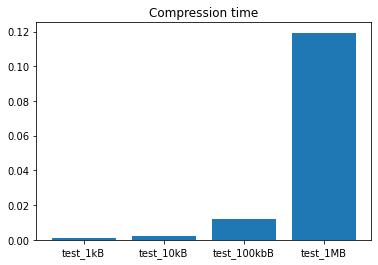

In [6]:
ds_names = [ds[0] for ds in datasets]
plt.bar(ds_names, static_compress_times)
plt.title("Compression time")

Text(0.5, 1.0, 'Decompresion time')

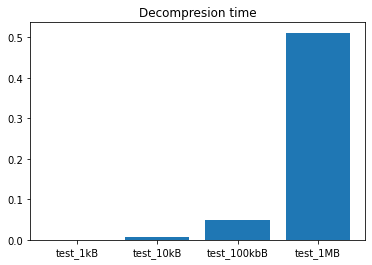

In [7]:
ds_names = [ds[0] for ds in datasets]
plt.bar(ds_names, static_decompress_times)
plt.title("Decompresion time")

Text(0.5, 1.0, 'Compression rate')

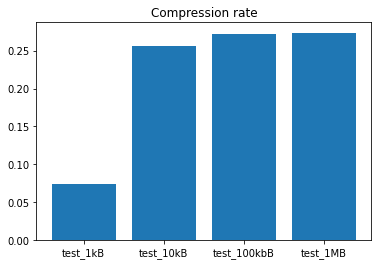

In [8]:
ds_names = [ds[0] for ds in datasets]
plt.bar(ds_names, static_compression_rate)
plt.title("Compression rate")